In [201]:
import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from shapely.geometry import Polygon

import bento as bt

mpl.style.use("dark_background")

import logging

logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
adata = bt.ds.load_dataset("merfish")


In [220]:
adata

AnnData object with n_obs × n_vars = 1153 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'cell_radius', 'cell_raster', 'fluxmap1_shape', 'fluxmap2_shape', 'fluxmap3_shape', 'fluxmap4_shape', 'fluxmap5_shape', 'n_genes_by_counts', 'total_counts', 'cell_area', 'cell_aspect_ratio', 'cell_density', 'nucleus_area', 'nucleus_aspect_ratio', 'nucleus_density'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'points', 'cell_raster', 'flux', 'flux_genes', 'flux_embed', 'flux_sv', 'flux_n_components', 'flux_counts', 'flux_variance_ratio', 'point_sets'
    layers: 'spliced', 'unspliced'

In [ ]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
bt.tl.obs_stats(adata)


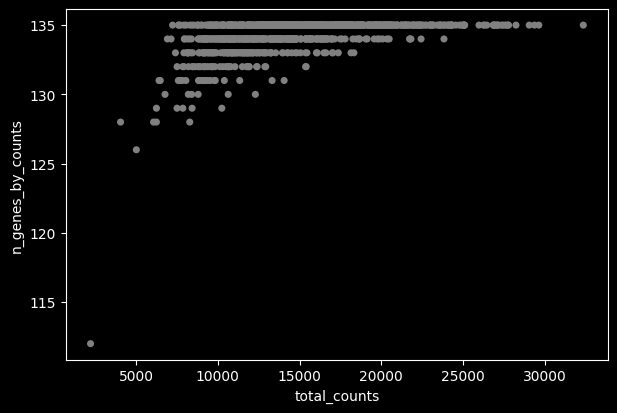

In [180]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")


In [ ]:
importlib.reload(bt.pl._multidimensional)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)

with sns.axes_style("white"):
    bt.pl.obs_stats(adata, rug=True, fname="u2os_obs_stats.svg")


In [3]:
importlib.reload(bt)
importlib.reload(bt.tl)
importlib.reload(bt.tl._flux)

r = 40
dx = 0.1
res = 0.1
bt.settings.log.setLevel("WARNING")

bt.tl.flux(adata, radius=r, train_size=1, use_highly_variable=False, res=res)


  0%|          | 0/1153 [00:00<?, ?it/s]

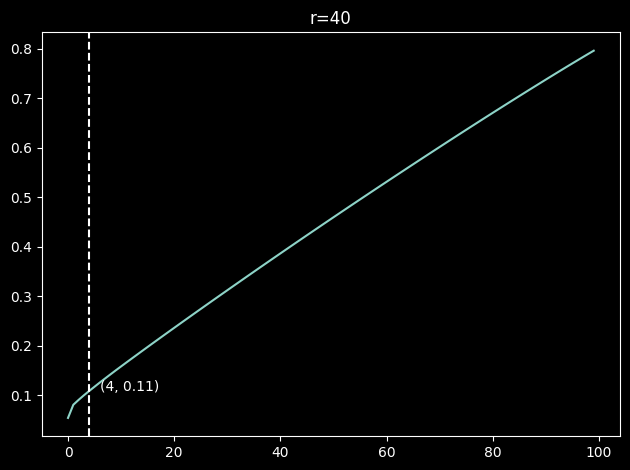

In [4]:
ax = sns.lineplot(np.cumsum(adata.uns["flux_variance_ratio"]))
elbow = adata.uns["flux_n_components"]
cumvar = np.sum(adata.uns["flux_variance_ratio"][: elbow + 1])
ax.axvline(elbow, ls="--")
ax.text(elbow + 2, cumvar, f"({elbow}, {cumvar:.2f})")
ax.set_title(f"r={r}")

plt.tight_layout()


In [5]:
bt.tl.fluxmap(adata, n_clusters=5, res=res, train_size=0.2)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/1153 [00:00<?, ?it/s]

In [6]:
adata_small = adata[adata.obs["batch"] == "8"]
adata_small.uns["points"] = adata_small.uns["points"].query("batch == 8")
adata_small.uns["points"]["batch"] = adata_small.uns["points"]["batch"].astype(str)
bt.sync(adata_small)


Saved to /home/ckmah/projects/spatial/figures/u2os_flux.svg


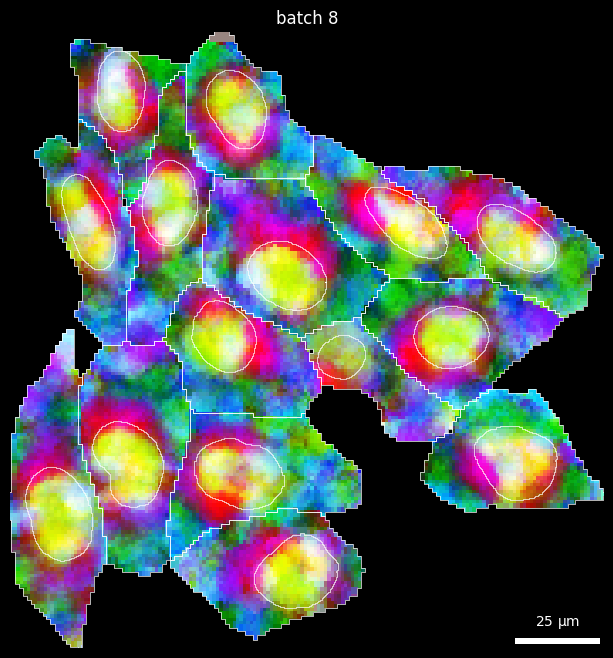

In [207]:
importlib.reload(bt.pl._utils)
importlib.reload(bt.pl._layers)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)

mpl.style.use("dark_background")
plt.figure(figsize=(8, 8))
bt.pl.flux(
    adata_small,
    res=res,
    alpha=False,
    dx=dx,
    title=None,
    frame_visible=False,
    fname="/home/ckmah/projects/spatial/figures/u2os_flux.svg",
)
# plt.title(f"radius={r:.2f}")


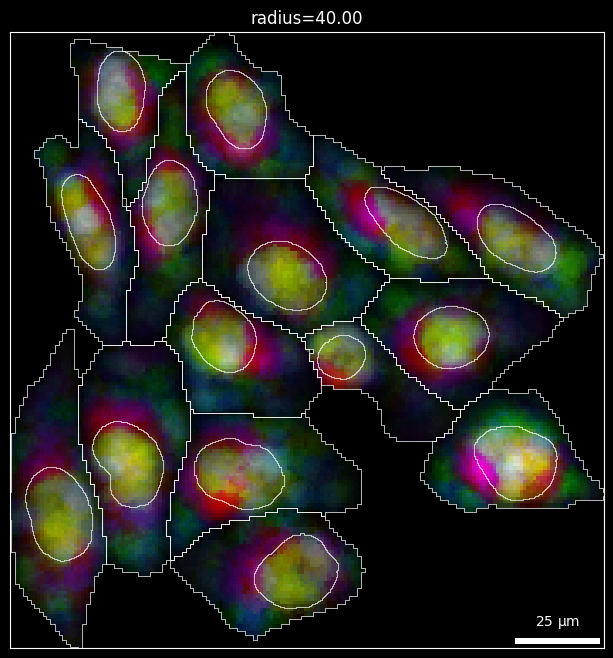

In [8]:
importlib.reload(bt.pl._utils)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)

mpl.style.use("dark_background")
plt.figure(figsize=(8, 8))

bt.pl.flux(adata_small, res=res, alpha=True, dx=dx, title=f"radius={r:.2f}")


Saved to /home/ckmah/projects/spatial/figures/u2os_points.svg


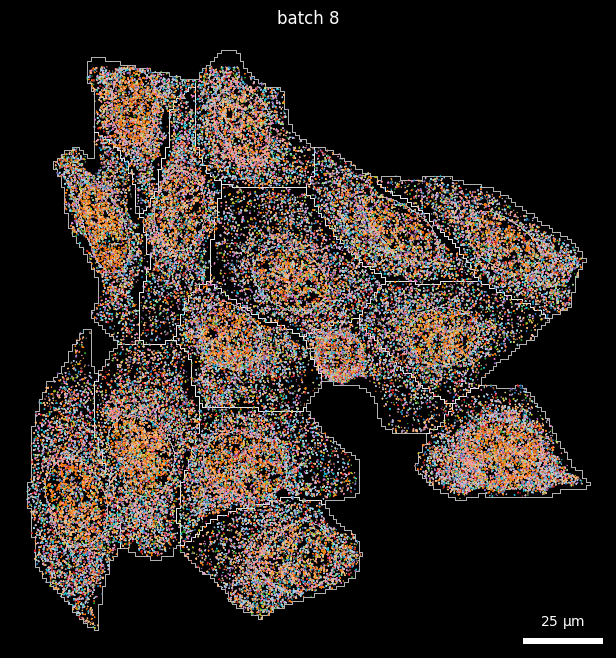

In [218]:
importlib.reload(bt.pl._utils)
importlib.reload(bt.pl._layers)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)

plt.figure(figsize=(8, 8))
bt.pl.points(adata_small, dx=dx, s=1, hue="gene", legend=False, palette="tab20", frame_visible=False, title="", fname="/home/ckmah/projects/spatial/figures/u2os_points.svg")


<Axes: >

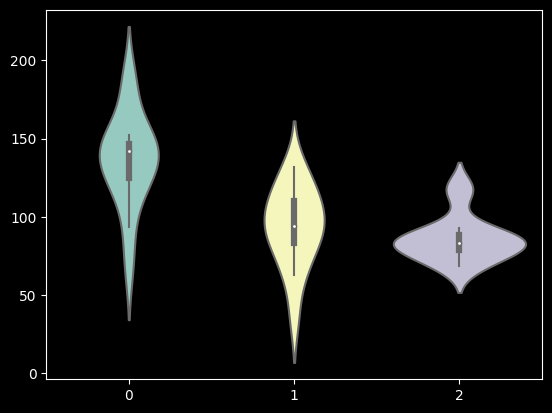

In [11]:
cell_flux = pd.DataFrame(adata_small.uns["flux_embed"][:, :3]).groupby(
    adata_small.uns["cell_raster"]["cell"].values
)
intra_var = cell_flux.var()
inter_var = cell_flux.mean().var()

sns.violinplot(
    data=intra_var / inter_var,
)


In [12]:
sns.color_palette(
    [
        "#FFD166",
        "#06D6A0",
        "#118ab2",
        "#396270",
        "#f78c6b",
        "#ef476f",
    ]
)


[(1.0, 0.8196078431372549, 0.4),
 (0.023529411764705882, 0.8392156862745098, 0.6274509803921569),
 (0.06666666666666667, 0.5411764705882353, 0.6980392156862745),
 (0.2235294117647059, 0.3843137254901961, 0.4392156862745098),
 (0.9686274509803922, 0.5490196078431373, 0.4196078431372549),
 (0.9372549019607843, 0.2784313725490196, 0.43529411764705883)]

Saved to /home/ckmah/projects/spatial/figures/u2os_fluxmap.svg


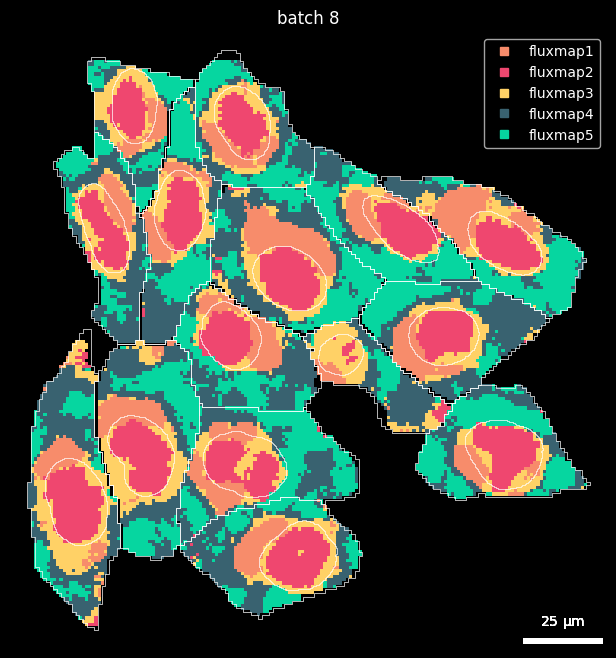

In [225]:
importlib.reload(bt.pl._utils)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)

fig = plt.figure(figsize=(8, 8))
bt.pl.fluxmap(
    adata_small,
    dx=dx,
    palette=[bt.colors.bento6[i] for i in [4, 5, 0, 3, 1]],
    linewidth=0,
    frame_visible=False,
    legend=True,
    fname="/home/ckmah/projects/spatial/figures/u2os_fluxmap.svg",
)
# plt.legend()


In [25]:
adata_small.uns["comp_stats"] = bt.tl._composition._get_compositions(
    adata_small.uns["points"],
    shape_names=[
        "fluxmap1_shape",
        "fluxmap2_shape",
        "fluxmap3_shape",
        "fluxmap4_shape",
        "fluxmap5_shape",
    ],
)


[14:08:03] WARNING  No artists with labels found to put in legend.  Note that artists whose label    ]8;id=206386;file:///home/ckmah/miniconda3/envs/bentov2/lib/python3.9/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=499440;file:///home/ckmah/miniconda3/envs/bentov2/lib/python3.9/site-packages/matplotlib/legend.py#1323\1323]8;;\
                    start with an underscore are ignored when legend() is called with no argument.                 

Adjusting text positions...
Saved to /home/ckmah/projects/spatial/figures/u2os_flux_summary.svg


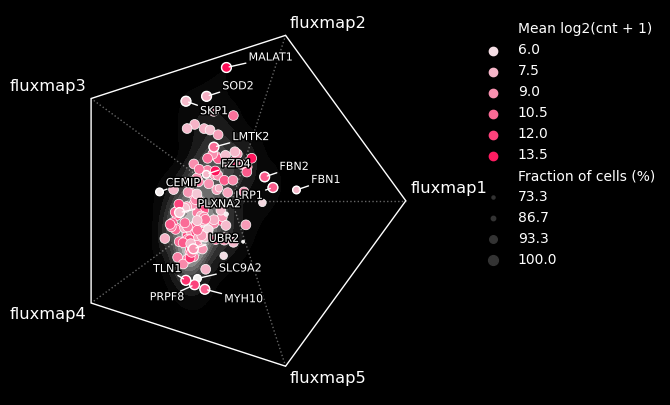

In [215]:
importlib.reload(bt.pl._multidimensional)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)


from IPython.display import display

top_genes = []
for i in range(1, 6):
    top_g = (
        adata_small.uns["comp_stats"]
        .sort_values(f"fluxmap{i}", ascending=False)
        .head(3)
        .index.tolist()
    )
    top_genes.extend(top_g)

bt.pl.flux_summary(
    adata_small,
    annotate=top_genes,
    annot_color="white",
    size_norm=(85, 100),
    sizes=(5, 50),
    fname="/home/ckmah/projects/spatial/figures/u2os_flux_summary.svg",
)


In [85]:
adata_small.uns["point_sets"]["points"] = []


In [95]:
importlib.reload(bt.pl._layers)
importlib.reload(bt.pl._plotting)
importlib.reload(bt.pl)


<module 'bento.plotting' from '/projects/ps-yeolab4/spatial_project/bento-tools/bento/plotting/__init__.py'>

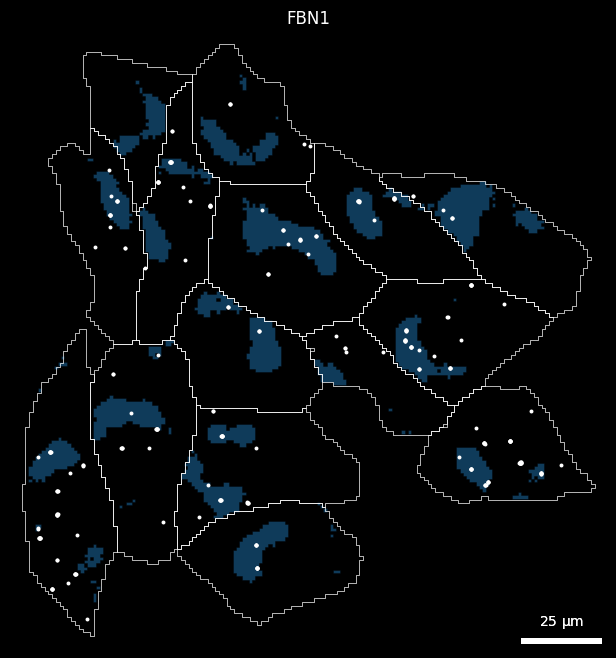

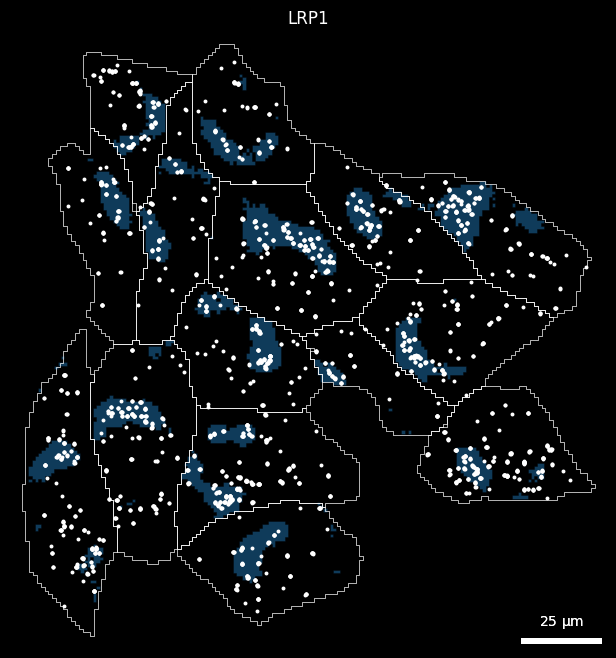

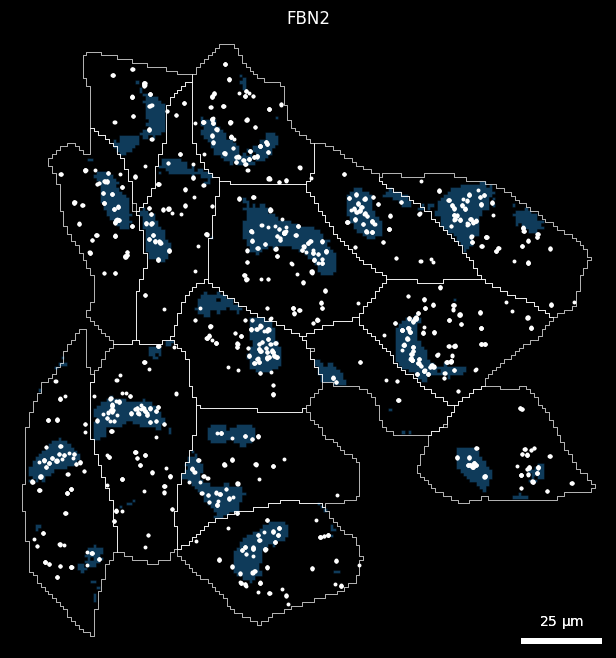

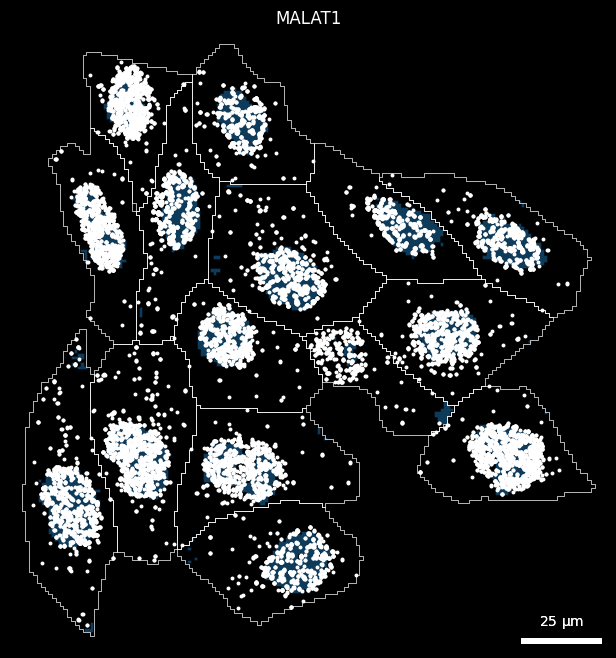

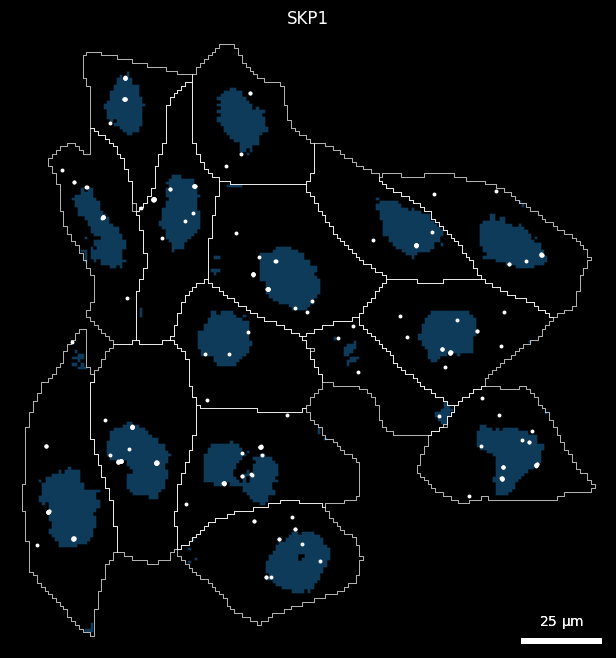

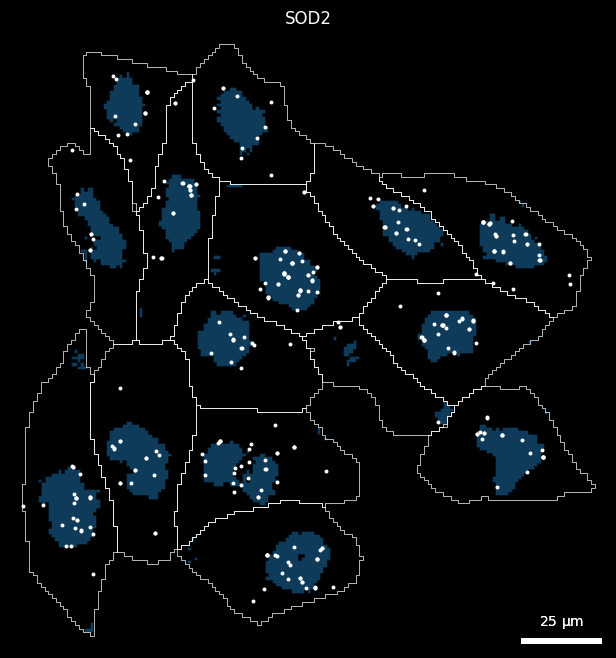

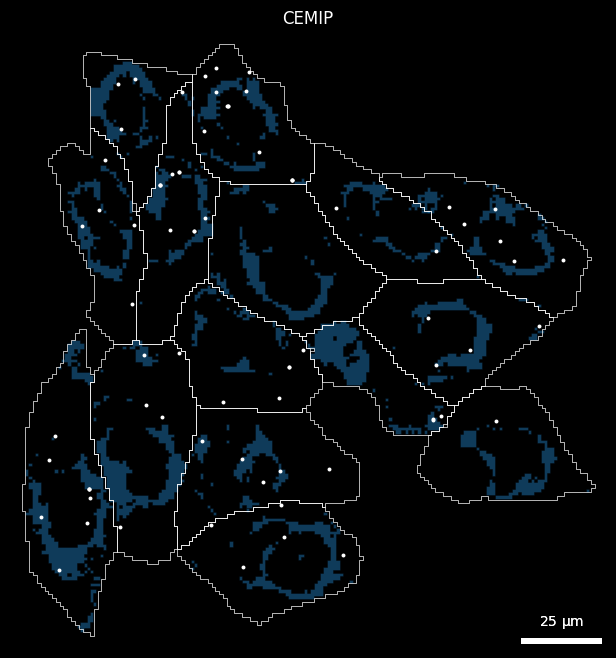

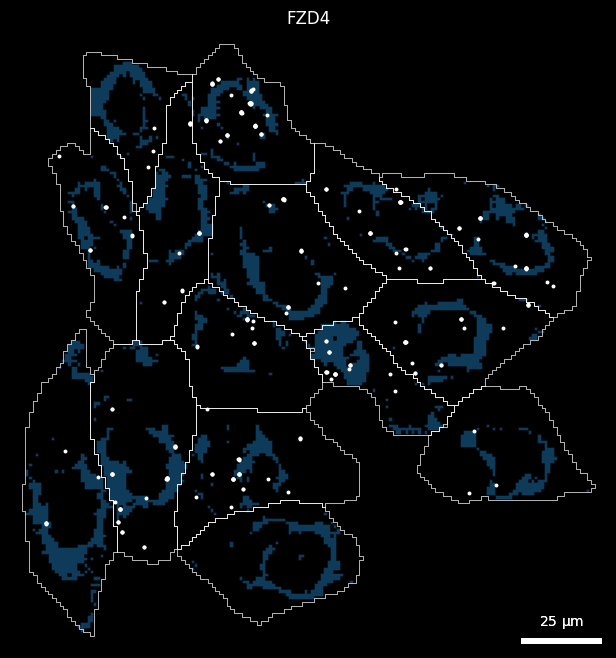

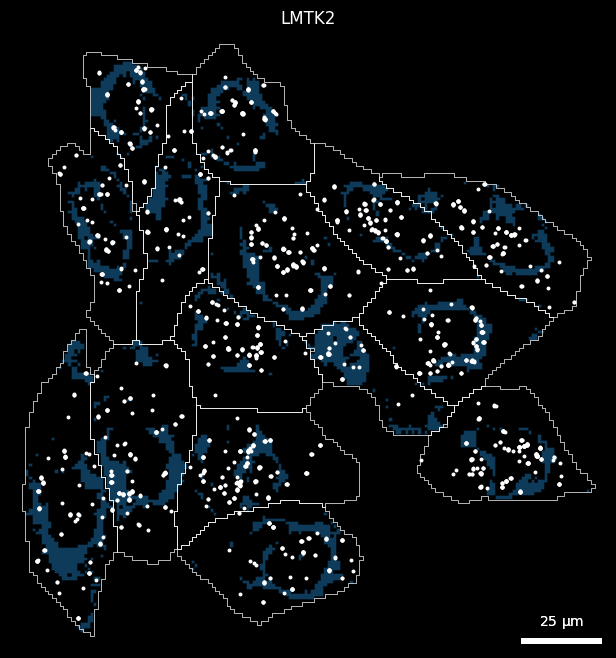

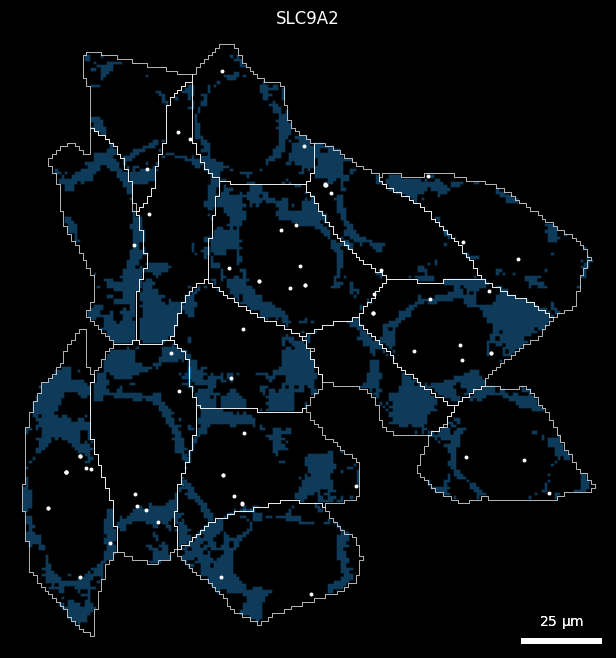

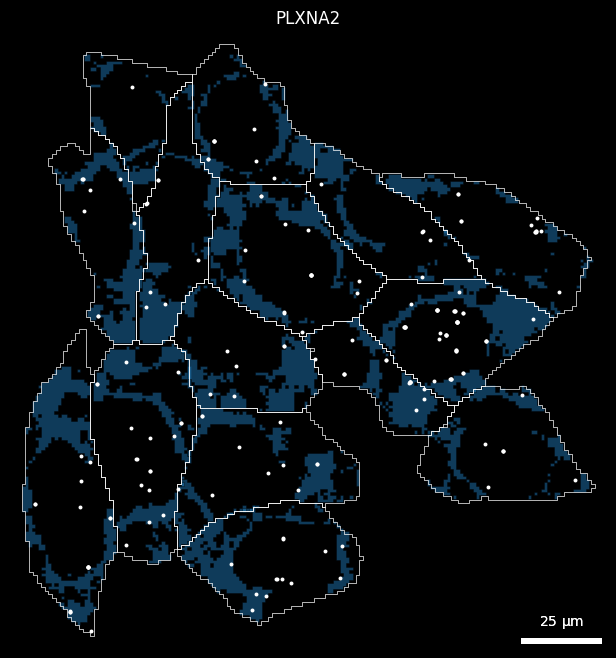

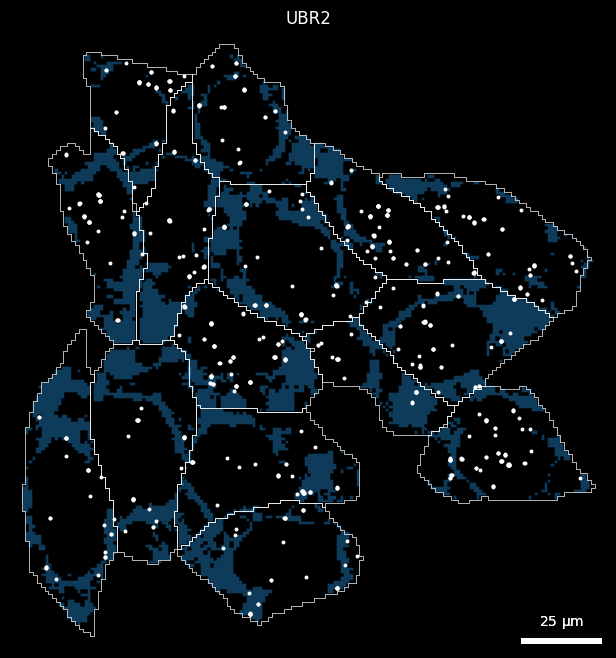

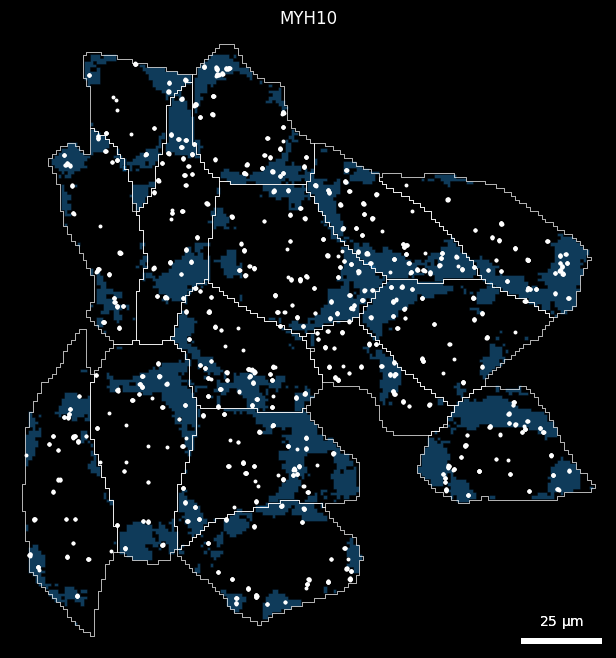

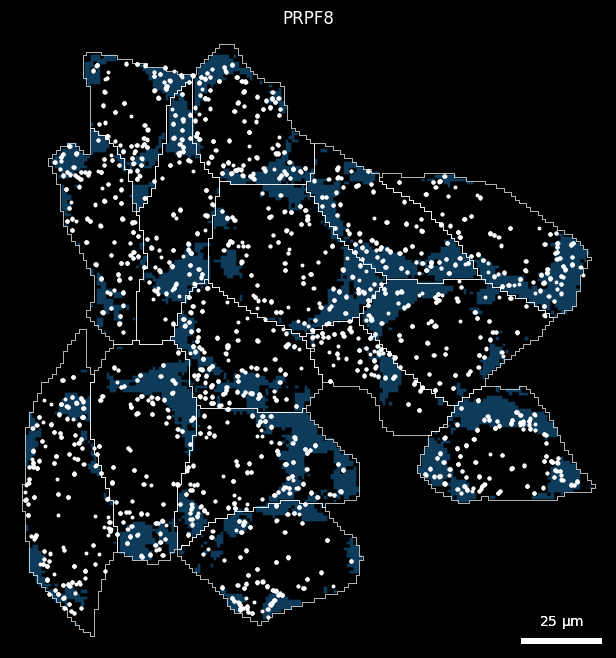

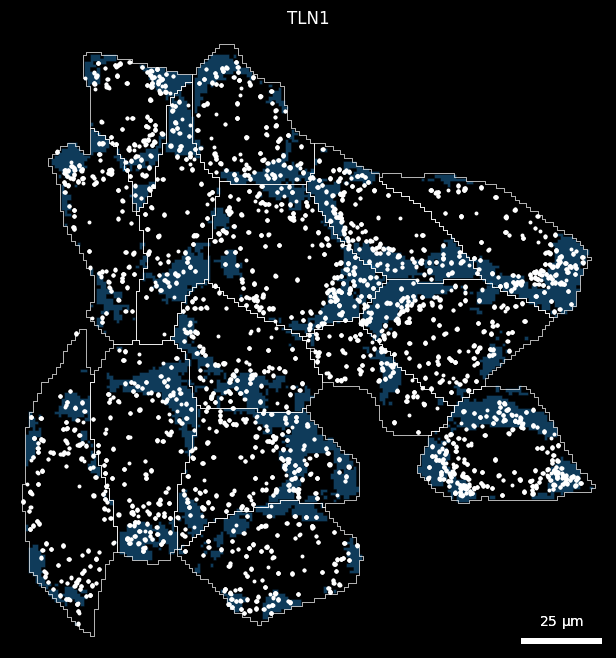

In [133]:
shape_paired = (
    ["fluxmap1_shape"] * 3
    + ["fluxmap2_shape"] * 3
    + ["fluxmap3_shape"] * 3
    + ["fluxmap4_shape"] * 3
    + ["fluxmap5_shape"] * 3
)
for g, s in zip(top_genes, shape_paired):
    fig = plt.figure(figsize=(8, 8))
    bt.pl.shapes(
        adata_small,
        shapes=[s],
        color="tab:blue",
        color_style="fill",
        alpha=0.5,
        frame_visible=False,
    )

    bt.pl.points(
        adata_small[:, g],
        shapes=["cell_shape"],
        s=8,
        c="white",
        title=g,
        frame_visible=False,
    )
    # break


In [14]:
bt.tl.fe_fazal2019(adata_small)


11 samples of mat are empty, they will be removed.
Running wsum on mat with 19316 samples and 135 targets for 8 sources.
Infering activities on 2 batches.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


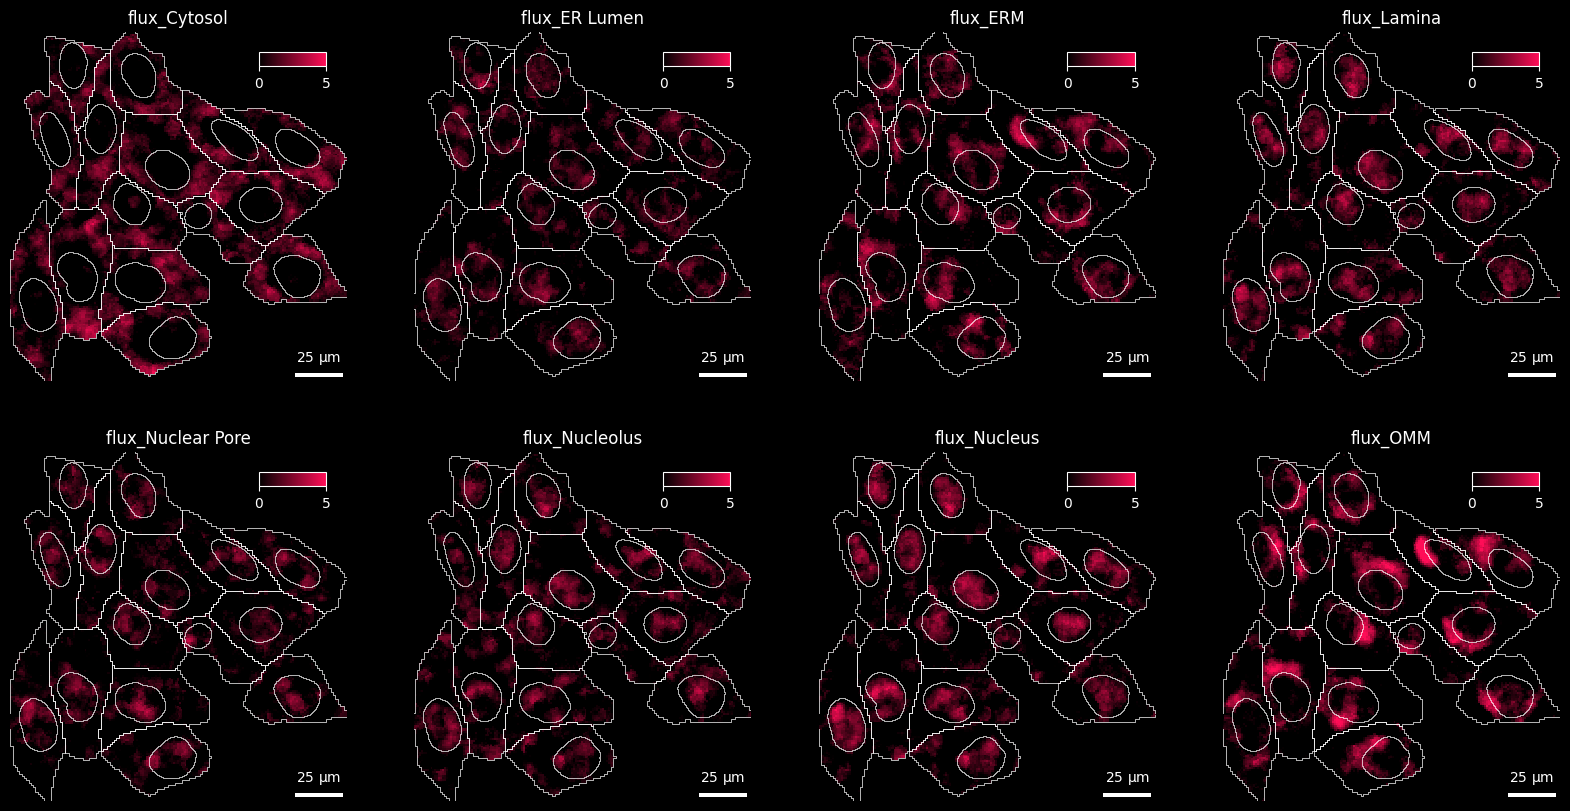

In [15]:
genesets = [
    "flux_Cytosol",
    "flux_ER Lumen",
    "flux_ERM",
    "flux_Lamina",
    "flux_Nuclear Pore",
    "flux_Nucleolus",
    "flux_Nucleus",
    "flux_OMM",
]

for gs, ax in zip(genesets, axes.flat):
    bt.pl.fe(
        adata_small,
        gs,
        cmap=bt.colors.red_dark,
        vmin=0,
        vmax=5,
        frame_visible=False,
        dx=dx,
        title=gs,
        ax=ax,
    )


In [16]:
adata_small.uns["cell_raster"]["fluxmap"].unique()


array([3, 2, 4, 5, 1, 0])

Saved to /home/ckmah/projects/spatial/figures/u2os_domain_fazal2019.svg


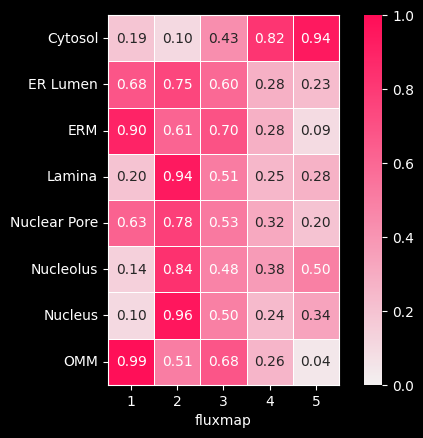

In [219]:
@bt.pl._utils.savefig
def plot_domain_fe(data, fname=None):
    domains = [
        "flux_Cytosol",
        "flux_ER Lumen",
        "flux_ERM",
        "flux_Lamina",
        "flux_Nuclear Pore",
        "flux_Nucleolus",
        "flux_Nucleus",
        "flux_OMM",
    ]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )

    # Count fraction of samples with flux > 1
    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).apply(
        lambda x: (x > 0).sum() / x.shape[0]
    )
    domain_fe.columns = [d.split("flux_")[1] for d in domain_fe.columns]
    domain_fe = domain_fe.dropna(axis=0)

    domain_fe = domain_fe.iloc[1:, :]

    with mpl.style.context("dark_background"):
        ax = sns.heatmap(
            domain_fe.T,
            vmin=0,
            vmax=1,
            lw=0.5,
            cmap=bt.colors.red_light,
            square=True,
            annot=True,
            fmt=".2f",
        )
        ax.spines[:].set_visible(True)


plot_domain_fe(adata_small, fname="/home/ckmah/projects/spatial/figures/u2os_domain_fazal2019.svg")


In [228]:
adata_small.uns["fe_stats"].max()


Cytosol         63
ER Lumen        63
ERM             63
Lamina          63
Nuclear Pore    63
Nucleolus       63
Nucleus         63
OMM             63
dtype: int64

TODO: Plot specific pairs of fluxmaps and genesets.


Saved to /home/ckmah/projects/spatial/figures/u2os_fluxmap1_OMM.svg
Saved to /home/ckmah/projects/spatial/figures/u2os_fluxmap2_Nucleus.svg
Saved to /home/ckmah/projects/spatial/figures/u2os_fluxmap3_ERM.svg
Saved to /home/ckmah/projects/spatial/figures/u2os_fluxmap4_Cytosol.svg
Saved to /home/ckmah/projects/spatial/figures/u2os_fluxmap5_Cytosol.svg


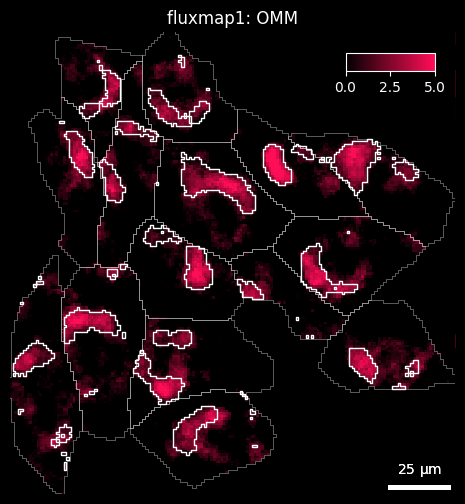

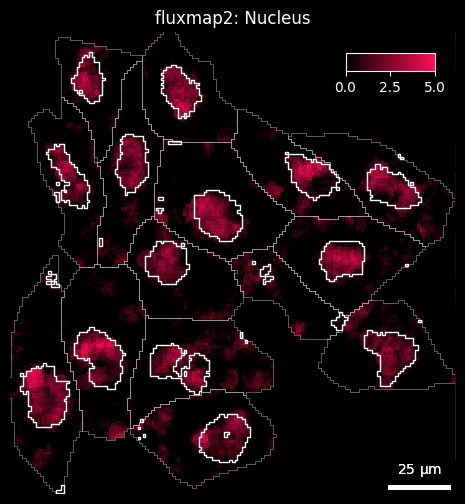

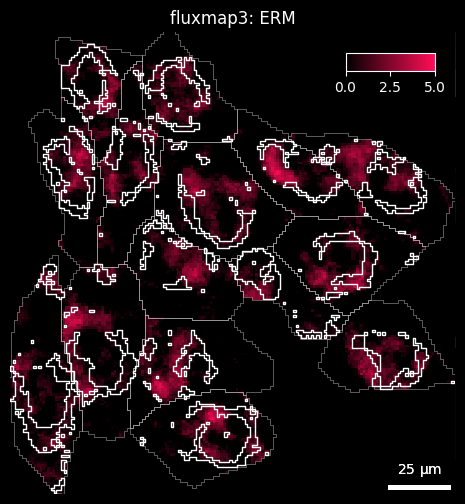

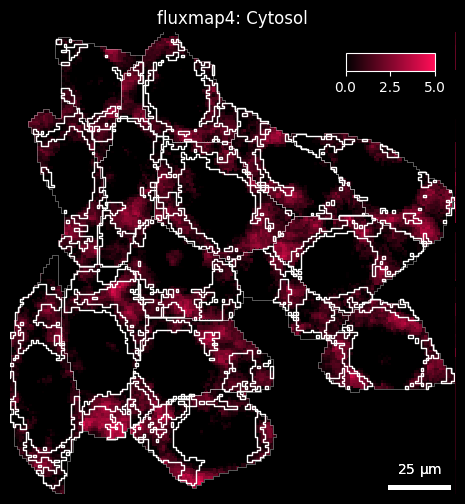

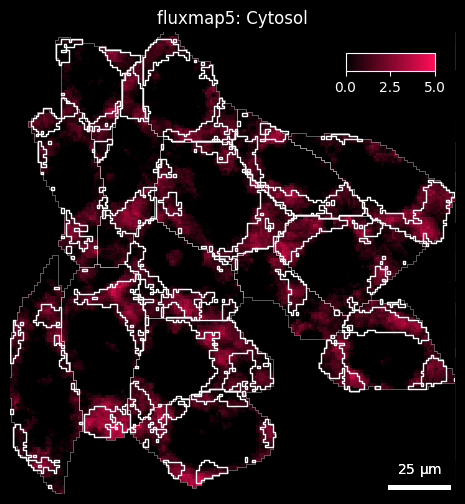

In [216]:
fluxmaps = [f"fluxmap{i}" for i in range(0, 6)]
genesets = ["", "flux_OMM", "flux_Nucleus", "flux_ERM", "flux_Cytosol", "flux_Cytosol"]


for fm, gs in zip(fluxmaps, genesets):
    if gs == "":
        continue

    gs_title = gs.replace("flux_", "")
    plt.figure(figsize=(6, 6))
    bt.pl.shapes(adata_small, shapes=["cell_shape"], alpha=0.5)
    bt.pl.fe(
        adata_small,
        gs,
        shapes=[fm],
        cmap=bt.colors.red_dark,
        vmin=0,
        vmax=5,
        dx=dx,
        title=f"{fm}: {gs_title}",
        frame_visible=False,
        shape_kws=dict(lw=1),
        fname=f"/home/ckmah/projects/spatial/figures/u2os_{fm}_{gs_title}.svg",
    )


In [19]:
pc_weights = pd.DataFrame(
    adata.uns["flux_sv"][:25],
    index=[f"PC{i}" for i in range(25)],
    columns=adata.uns["flux_genes"],
)


In [20]:
import decoupler as dc

fazal2019 = bt.tl.load_gene_sets("fazal2019")
fazal2019 = fazal2019.pivot(index="source", columns="target", values="weight").T.fillna(
    0
)
fazal2019.head()


source,Cytosol,ER Lumen,ERM,Lamina,Nuclear Pore,Nucleolus,Nucleus,OMM
target,,,,,,,,
AARS2,-0.280999,0.044633,0.357659,-0.195066,0.291704,-1.225867,0.179871,2.715643
AASDH,-0.290857,-0.470415,-0.616271,0.753356,-0.602657,1.096525,0.418622,-0.845593
AASS,0.016639,-0.131917,1.740126,0.443978,0.529793,0.864569,0.302249,4.236737
ABCA3,-0.011081,0.117976,1.117785,-0.109083,0.119327,-0.427571,-0.308186,1.289387
ABCB10,-0.950674,-0.511049,-0.726714,0.272038,-0.602548,0.247002,-0.144214,1.350953


In [21]:
common_genes = set(fazal2019.index).intersection(set(pc_weights.columns))


In [22]:
all_df = pd.concat([pc_weights[common_genes].T, fazal2019.loc[common_genes]], axis=1)
